In [10]:
import numpy as np
import pandas as pd

from sklearn.metrics import auc, roc_auc_score, plot_roc_curve, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from IPython.display import display

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split


data = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")
data.fillna(0, inplace=True)

features = [
            'latitude',
            'longitude',
            'housing_median_age',
            'total_rooms',
            'total_bedrooms',
            'population',
            'households',
            'median_income',
            'median_house_value',
            'ocean_proximity'
        ]

data["median_house_value"] = np.log1p(data["median_house_value"].values)

data_full_train, data_test = train_test_split(data, test_size=0.2, random_state=1)
data_train, data_valid = train_test_split(data_full_train, test_size=0.25, random_state=1)

data_full_train.reset_index(drop=True, inplace=True)

data_train.reset_index(drop=True, inplace=True)
data_valid.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

y_train = data_train.pop("median_house_value")
y_valid = data_valid.pop("median_house_value")
y_test = data_test.pop("median_house_value")
y_full_train = data_full_train.pop("median_house_value")

dict_train = data_train.to_dict(orient="records")
dict_valid = data_valid.to_dict(orient="records")
dict_full_train = data_full_train.to_dict(orient="records")

dict_test = data_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_valid = dv.transform(dict_valid)
X_full_train = dv.transform(dict_full_train)

[Text(0.5, 0.75, 'ocean_proximity=INLAND <= 0.5\nsquared_error = 0.322\nsamples = 12384\nvalue = 12.088'),
 Text(0.25, 0.25, 'squared_error = 0.214\nsamples = 8483\nvalue = 12.307'),
 Text(0.75, 0.25, 'squared_error = 0.227\nsamples = 3901\nvalue = 11.613')]

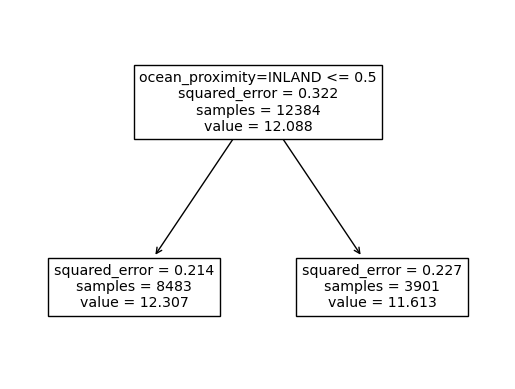

In [3]:
# Question 1

dt = DecisionTreeRegressor(max_depth=1)

dt.fit(X_train, y_train)

display(plot_tree(dt, feature_names=dv.get_feature_names_out()))

In [4]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



In [5]:
# Question 2
params = {
    "n_estimators": 10,
    "random_state": 1,
    "n_jobs": -1
}

rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

y_valid_predict = rf.predict(X_valid)

rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
print("RMSE on valid dataset %9s" %rmse.round(2))

RMSE on valid dataset      0.25


In [6]:
def train_rf(max_depth=None):
    num_estimators = np.linspace(10, 200, 20).astype("int")

    params = {
        "random_state": 1,
        "n_jobs": -1
    }

    results = []

    for num in tqdm(num_estimators):
        scores = {}

        rf = RandomForestRegressor(n_estimators=num, max_depth=max_depth, **params)
        rf.fit(X_train, y_train)
        
        y_valid_predict = rf.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)

        scores["num_estimators"] = num
        scores["rmse"] = rmse
        
        results.append(scores)

    results_df = pd.DataFrame(results)

    return results_df

results_df = train_rf()

100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


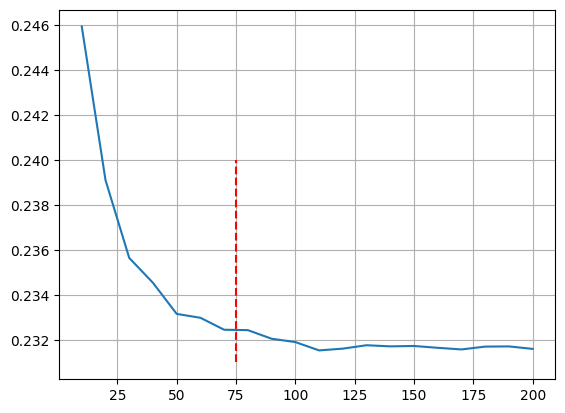

In [7]:
plt.plot(results_df.num_estimators, results_df.rmse)
# plt.ylim(0.23, 0.234)
plt.vlines(x=75, ymin=0.231, ymax=0.24, color='r', linestyles='dashed')
plt.grid()

In [97]:
from sklearn import ensemble


depths = [10, 15, 20, 25]

ensemble_scores = {}
for depth in tqdm(depths):

    ensemble_scores[depth] = train_rf(max_depth=depth)

100%|██████████| 4/4 [02:34<00:00, 38.69s/it]


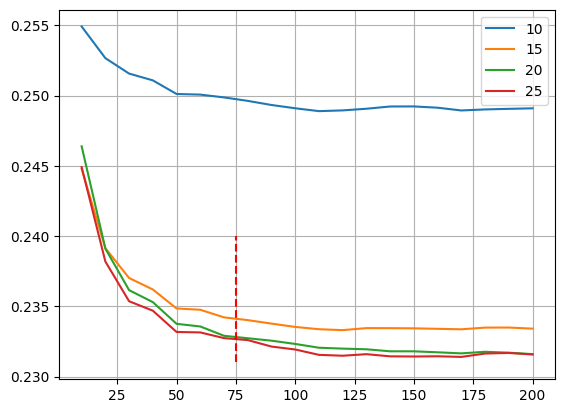

In [100]:
for depth, results_df in ensemble_scores.items():
    plt.plot(results_df.num_estimators, results_df.rmse, label=depth)

plt.legend()
# plt.ylim(0.23, 0.234)
plt.vlines(x=75, ymin=0.231, ymax=0.24, color='r', linestyles='dashed')
plt.grid()

In [8]:
# Question 5
params = {
        "n_estimators": 10,
        "max_depth": 20,
        "random_state": 1,
        "n_jobs": -1
    }

rf = RandomForestRegressor(**params)
rf.fit(X_train, y_train)

y_valid_predict = rf.predict(X_valid)
rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
print(rmse)

0.24638657024164587


In [9]:
feature_importances = list(zip(dv.feature_names_, rf.feature_importances_))
sorted(feature_importances, key=lambda x: x[1], reverse=True)

[('median_income', 0.36366102999455063),
 ('ocean_proximity=INLAND', 0.3109008414649182),
 ('latitude', 0.10154547618368868),
 ('longitude', 0.09632464688219677),
 ('housing_median_age', 0.03293146678518498),
 ('population', 0.029629759818677763),
 ('total_rooms', 0.021807414790053964),
 ('total_bedrooms', 0.018239616242627415),
 ('households', 0.01707949729751655),
 ('ocean_proximity=NEAR OCEAN', 0.0042237262548374226),
 ('ocean_proximity=<1H OCEAN', 0.0028781968739456333),
 ('ocean_proximity=NEAR BAY', 0.000421521148856216),
 ('ocean_proximity=ISLAND', 0.000356806262945808)]

In [101]:
%%capture output

etas = [0.3, 0.1]

scores_logs = {}

for eta in tqdm(etas):
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',

        'seed': 1,
        'verbosity': 1
    }

    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dfulltrain = xgb.DMatrix(X_full_train, y_full_train)

    watchlist = [(dtrain, "train"), (dvalid, "valid")]
    model = xgb.train(dtrain=dtrain, params=xgb_params, num_boost_round=100, evals=watchlist)

scores_logs = output.stdout


In [102]:
logs_tab = [record.split('\t') for record in scores_logs.split('\n')][:-1]
scores = []

for log in logs_tab:
    print(log)
    scores_dict = {}
    scores_dict["n_iter"] = log[0].strip('[]')
    scores_dict["train-rmse"] = float(log[1].split(":")[1])
    scores_dict["valid-rmse"] = float(log[2].split(":")[1])

    scores.append(scores_dict)

scored_df = pd.DataFrame(scores)

['[0]', 'train-rmse:8.12733', 'valid-rmse:8.13245']
['[1]', 'train-rmse:5.69586', 'valid-rmse:5.70070']
['[2]', 'train-rmse:3.99540', 'valid-rmse:4.00041']
['[3]', 'train-rmse:2.80712', 'valid-rmse:2.81079']
['[4]', 'train-rmse:1.97834', 'valid-rmse:1.98175']
['[5]', 'train-rmse:1.40218', 'valid-rmse:1.40741']
['[6]', 'train-rmse:1.00099', 'valid-rmse:1.00700']
['[7]', 'train-rmse:0.72751', 'valid-rmse:0.73439']
['[8]', 'train-rmse:0.54190', 'valid-rmse:0.55047']
['[9]', 'train-rmse:0.42167', 'valid-rmse:0.43233']
['[10]', 'train-rmse:0.34481', 'valid-rmse:0.35782']
['[11]', 'train-rmse:0.29835', 'valid-rmse:0.31360']
['[12]', 'train-rmse:0.27095', 'valid-rmse:0.28865']
['[13]', 'train-rmse:0.25268', 'valid-rmse:0.27334']
['[14]', 'train-rmse:0.24295', 'valid-rmse:0.26605']
['[15]', 'train-rmse:0.23555', 'valid-rmse:0.26044']
['[16]', 'train-rmse:0.22630', 'valid-rmse:0.25229']
['[17]', 'train-rmse:0.22233', 'valid-rmse:0.24902']
['[18]', 'train-rmse:0.22029', 'valid-rmse:0.24826']
['[

In [104]:
scores_dict = {
    eta: pd.DataFrame(df.reshape(-1, 3), columns=["num", "train-rmse", "valid-rmse"]) \
    for eta, df in zip(etas, scored_df.values.reshape(-1,300))}

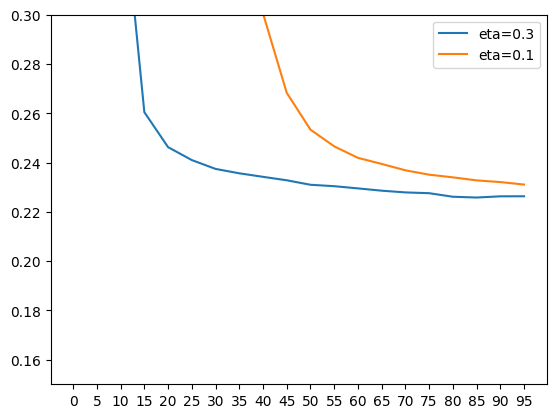

In [110]:
for eta in etas:
    plt.plot(scores_dict[eta][::5].num, scores_dict[eta]["valid-rmse"][::5], label=f"eta={eta}")
plt.ylim(0.15, 0.30)
plt.legend()
